In [ ]:
import os
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd
import numpy as np
from PIL import Image
import timm
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import subprocess
subprocess.run(['pip', 'install', '-q', 'nltk', 'rouge-score'], check=True)

import nltk
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

print("Libraries installed and imported!")

✓ Libraries installed and imported!


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n Using device: {device}")


🖥️  Using device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Define paths
BASE_PATH = '/content/drive/MyDrive/flickr30k_images'
IMAGES_PATH = BASE_PATH
PROCESSED_PATH = os.path.join(BASE_PATH, 'processed')
CHECKPOINT_DIR = os.path.join(PROCESSED_PATH, 'checkpoints')
RESULTS_DIR = os.path.join(PROCESSED_PATH, 'evaluation_results')
os.makedirs(RESULTS_DIR, exist_ok=True)

print(f"\n Paths:")
print(f"   Checkpoints: {CHECKPOINT_DIR}")
print(f"   Results will be saved to: {RESULTS_DIR}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

📁 Paths:
   Checkpoints: /content/drive/MyDrive/flickr30k_images/processed/checkpoints
   Results will be saved to: /content/drive/MyDrive/flickr30k_images/processed/evaluation_results


In [ ]:
class Config:
    base_path = BASE_PATH
    images_path = IMAGES_PATH
    processed_path = PROCESSED_PATH
    checkpoint_dir = CHECKPOINT_DIR
    results_dir = RESULTS_DIR

    img_size = 224
    swin_model_name = 'swin_tiny_patch4_window7_224'
    swin_embed_dim = 768
    freeze_swin = True
    gpt2_model_name = 'gpt2'
    gpt2_embed_dim = 768
    max_length = 50

    batch_size = 64  # Larger batch size for faster inference
    num_workers = 2

    bos_token = '<|startoftext|>'
    eos_token = '<|endoftext|>'
    pad_token = '<|pad|>'

    device = device

config = Config()
print(f" Configuration loaded")

✓ Configuration loaded


In [ ]:
test_transform = transforms.Compose([
    transforms.Resize((config.img_size, config.img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# Initialize tokenizer
tokenizer = GPT2Tokenizer.from_pretrained(config.gpt2_model_name)
special_tokens = {
    'pad_token': config.pad_token,
    'bos_token': config.bos_token,
    'eos_token': config.eos_token
}
tokenizer.add_special_tokens(special_tokens)
print(f" Tokenizer loaded (vocab size: {len(tokenizer):,})")

✓ Tokenizer loaded (vocab size: 50,259)


In [ ]:
class FlickrTestDataset(Dataset):
    def __init__(self, captions_file, images_dir, transform):
        self.df = pd.read_csv(captions_file)

        # Group by image to get all 5 captions per image
        self.image_groups = self.df.groupby('image')['caption'].apply(list).reset_index()

        self.images_dir = images_dir
        self.transform = transform

        print(f"   Loaded {len(self.image_groups)} unique images")
        print(f"   Total caption references: {len(self.df)}")

    def __len__(self):
        return len(self.image_groups)

    def __getitem__(self, idx):
        row = self.image_groups.iloc[idx]
        img_name = row['image']
        captions = row['caption']  # List of all 5 captions

        # Load image
        img_path = os.path.join(self.images_dir, img_name)
        try:
            image = Image.open(img_path).convert('RGB')
            image = self.transform(image)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            image = torch.zeros(3, 224, 224)

        return {
            'image': image,
            'image_name': img_name,
            'captions': captions  # List of reference captions
        }

In [ ]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, config, tokenizer):
        super(ImageCaptioningModel, self).__init__()
        self.config = config
        self.tokenizer = tokenizer

        self.swin = timm.create_model(
            config.swin_model_name,
            pretrained=True,
            num_classes=0
        )

        if config.freeze_swin:
            for param in self.swin.parameters():
                param.requires_grad = False

        self.projection = nn.Linear(config.swin_embed_dim, config.gpt2_embed_dim)
        self.gpt2 = GPT2LMHeadModel.from_pretrained(config.gpt2_model_name)
        self.gpt2.resize_token_embeddings(len(tokenizer))

        self.image_prefix_length = 1

    def forward(self, images, caption_ids, attention_mask):
        batch_size = images.size(0)

        with torch.set_grad_enabled(not self.config.freeze_swin):
            image_features = self.swin(images)

        image_embeds = self.projection(image_features).unsqueeze(1)
        caption_embeds = self.gpt2.transformer.wte(caption_ids)
        input_embeds = torch.cat([image_embeds, caption_embeds], dim=1)

        image_attention = torch.ones(batch_size, 1, device=attention_mask.device)
        full_attention_mask = torch.cat([image_attention, attention_mask], dim=1)

        outputs = self.gpt2(
            inputs_embeds=input_embeds,
            attention_mask=full_attention_mask,
            return_dict=True
        )

        logits = outputs.logits[:, self.image_prefix_length:, :]
        return logits

    def generate_caption(self, image, max_length=50):
        """Generate caption for a single image"""
        self.eval()
        with torch.no_grad():
            if image.dim() == 3:
                image = image.unsqueeze(0)
            image = image.to(self.config.device)

            # Extract features
            image_features = self.swin(image)
            image_embeds = self.projection(image_features).unsqueeze(1)

            # Start with BOS
            input_ids = torch.tensor([[self.tokenizer.bos_token_id]], device=self.config.device)

            # Generate tokens
            for _ in range(max_length):
                caption_embeds = self.gpt2.transformer.wte(input_ids)
                input_embeds = torch.cat([image_embeds, caption_embeds], dim=1)
                outputs = self.gpt2(inputs_embeds=input_embeds, return_dict=True)
                next_token_logits = outputs.logits[:, -1, :]
                next_token_id = torch.argmax(next_token_logits, dim=-1, keepdim=True)
                input_ids = torch.cat([input_ids, next_token_id], dim=1)

                if next_token_id.item() == self.tokenizer.eos_token_id:
                    break

            caption = self.tokenizer.decode(input_ids[0], skip_special_tokens=True)

        return caption

print("Model class defined")

✓ Model class defined


In [ ]:
best_checkpoint_path = os.path.join(config.checkpoint_dir, 'best_model.pt')

if not os.path.exists(best_checkpoint_path):
    print(f" Best model not found at {best_checkpoint_path}")
    print("Available checkpoints:")
    for f in os.listdir(config.checkpoint_dir):
        print(f"  - {f}")
    raise FileNotFoundError("Best model checkpoint not found!")

print(f" Loading checkpoint: {best_checkpoint_path}")

# Load checkpoint
checkpoint = torch.load(best_checkpoint_path, map_location=device)

# Create model
model = ImageCaptioningModel(config, tokenizer)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(config.device)
model.eval()

print(f"\n Model loaded successfully!")
print(f"   Trained for {checkpoint['epoch']} epochs")
print(f"   Best validation loss: {checkpoint['val_loss']:.4f}")


📂 Loading checkpoint: /content/drive/MyDrive/flickr30k_images/processed/checkpoints/best_model.pt

✓ Model loaded successfully!
   Trained for 3 epochs
   Best validation loss: 2.2924


In [ ]:
test_dataset = FlickrTestDataset(
    captions_file=os.path.join(config.processed_path, 'test_captions.csv'),
    images_dir=config.images_path,
    transform=test_transform
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
    pin_memory=True
)

print(f"\n Test dataset loaded")
print(f"   Images: {len(test_dataset)}")
print(f"   Batches: {len(test_loader)}")

   Loaded 1000 unique images
   Total caption references: 5000

✓ Test dataset loaded
   Images: 1000
   Batches: 16


In [ ]:
all_predictions = []
all_references = []
all_image_names = []

print(f"\n Generating captions for {len(test_dataset)} images...")

for batch in tqdm(test_loader, desc="Generating captions"):
    images = batch['image']
    image_names = batch['image_name']
    reference_captions = batch['captions']

    # reference_captions is a list of lists where each element contains 5 captions
    # We need to transpose it to get captions per image
    batch_size = len(images)

    # Generate captions for each image in batch
    for i in range(batch_size):
        image = images[i]
        img_name = image_names[i]

        # Get all 5 reference captions for this image
        # reference_captions is structured as: [[cap1_img1, cap1_img2, ...], [cap2_img1, cap2_img2, ...], ...]
        # We need to extract captions for image i
        try:
            refs = [reference_captions[j][i] for j in range(len(reference_captions))]
        except (IndexError, TypeError):
            # Fallback if structure is different
            refs = reference_captions[i] if isinstance(reference_captions[i], list) else [reference_captions[i]]

        predicted_caption = model.generate_caption(image, max_length=30)

        # Store results
        all_predictions.append(predicted_caption)
        all_references.append(refs)
        all_image_names.append(img_name)

print(f"\n Caption generation complete!")
print(f"   Total predictions: {len(all_predictions)}")

# Save predictions
predictions_df = pd.DataFrame({
    'image': all_image_names,
    'predicted_caption': all_predictions,
    'reference_captions': ['; '.join(refs) for refs in all_references]
})
predictions_df.to_csv(os.path.join(config.results_dir, 'predictions.csv'), index=False)
print(f" Predictions saved to predictions.csv")


🤖 Generating captions for 1000 images...


Generating captions:   0%|          | 0/16 [00:00<?, ?it/s]


✓ Caption generation complete!
   Total predictions: 1000
   💾 Predictions saved to predictions.csv


In [ ]:
references_tokenized = []
hypotheses_tokenized = []

for refs, pred in zip(all_references, all_predictions):
    # Tokenize references (all 5 captions for each image)
    refs_tokens = [ref.lower().split() for ref in refs]
    references_tokenized.append(refs_tokens)

    # Tokenize prediction
    pred_tokens = pred.lower().split()
    hypotheses_tokenized.append(pred_tokens)

# Calculate corpus BLEU scores
smoothing = SmoothingFunction()

bleu1 = corpus_bleu(references_tokenized, hypotheses_tokenized,
                    weights=(1.0, 0, 0, 0),
                    smoothing_function=smoothing.method1) * 100

bleu2 = corpus_bleu(references_tokenized, hypotheses_tokenized,
                    weights=(0.5, 0.5, 0, 0),
                    smoothing_function=smoothing.method1) * 100

bleu3 = corpus_bleu(references_tokenized, hypotheses_tokenized,
                    weights=(0.33, 0.33, 0.33, 0),
                    smoothing_function=smoothing.method1) * 100

bleu4 = corpus_bleu(references_tokenized, hypotheses_tokenized,
                    weights=(0.25, 0.25, 0.25, 0.25),
                    smoothing_function=smoothing.method1) * 100

print(f"\n BLEU Scores (Corpus):")
print(f"   BLEU-1: {bleu1:.2f}")
print(f"   BLEU-2: {bleu2:.2f}")
print(f"   BLEU-3: {bleu3:.2f}")
print(f"   BLEU-4: {bleu4:.2f}")



📊 BLEU Scores (Corpus):
   BLEU-1: 63.31
   BLEU-2: 42.39
   BLEU-3: 28.87
   BLEU-4: 19.21


In [ ]:
individual_bleu4_scores = []
for refs_tokens, pred_tokens in zip(references_tokenized, hypotheses_tokenized):
    score = sentence_bleu(refs_tokens, pred_tokens,
                         weights=(0.25, 0.25, 0.25, 0.25),
                         smoothing_function=smoothing.method1) * 100
    individual_bleu4_scores.append(score)

print(f"\n   Individual BLEU-4 statistics:")
print(f"      Mean: {np.mean(individual_bleu4_scores):.2f}")
print(f"      Median: {np.median(individual_bleu4_scores):.2f}")
print(f"      Std: {np.std(individual_bleu4_scores):.2f}")
print(f"      Min: {np.min(individual_bleu4_scores):.2f}")
print(f"      Max: {np.max(individual_bleu4_scores):.2f}")


   Individual BLEU-4 statistics:
      Mean: 17.26
      Median: 11.23
      Std: 15.40
      Min: 1.58
      Max: 100.00


In [ ]:
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

rouge_l_scores = []

for refs, pred in zip(all_references, all_predictions):
    # Calculate ROUGE-L against all references and take the max
    scores = []
    for ref in refs:
        score = scorer.score(ref, pred)
        scores.append(score['rougeL'].fmeasure)

    # Take maximum score across all references
    max_score = max(scores)
    rouge_l_scores.append(max_score * 100)

rouge_l_mean = np.mean(rouge_l_scores)

print(f"\n ROUGE Scores:")
print(f"   ROUGE-L: {rouge_l_mean:.2f}")
print(f"      Mean: {rouge_l_mean:.2f}")
print(f"      Median: {np.median(rouge_l_scores):.2f}")
print(f"      Std: {np.std(rouge_l_scores):.2f}")
print(f"      Min: {np.min(rouge_l_scores):.2f}")
print(f"      Max: {np.max(rouge_l_scores):.2f}")



📊 ROUGE Scores:
   ROUGE-L: 42.95
      Mean: 42.95
      Median: 41.67
      Std: 13.78
      Min: 9.52
      Max: 100.00


In [ ]:
results = {
    'corpus_scores': {
        'BLEU-1': float(bleu1),
        'BLEU-2': float(bleu2),
        'BLEU-3': float(bleu3),
        'BLEU-4': float(bleu4),
        'ROUGE-L': float(rouge_l_mean)
    },
    'individual_bleu4_stats': {
        'mean': float(np.mean(individual_bleu4_scores)),
        'median': float(np.median(individual_bleu4_scores)),
        'std': float(np.std(individual_bleu4_scores)),
        'min': float(np.min(individual_bleu4_scores)),
        'max': float(np.max(individual_bleu4_scores))
    },
    'rouge_l_stats': {
        'mean': float(rouge_l_mean),
        'median': float(np.median(rouge_l_scores)),
        'std': float(np.std(rouge_l_scores)),
        'min': float(np.min(rouge_l_scores)),
        'max': float(np.max(rouge_l_scores))
    },
    'num_test_samples': len(all_predictions),
    'model_checkpoint': best_checkpoint_path,
    'trained_epochs': checkpoint['epoch']
}

with open(os.path.join(config.results_dir, 'evaluation_scores.json'), 'w') as f:
    json.dump(results, f, indent=4)

print(f"\n Results saved to evaluation_scores.json")

# Add individual scores to predictions dataframe
predictions_df['bleu4_score'] = individual_bleu4_scores
predictions_df['rouge_l_score'] = rouge_l_scores
predictions_df.to_csv(os.path.join(config.results_dir, 'predictions_with_scores.csv'), index=False)

print(f" Predictions with scores saved to predictions_with_scores.csv")


💾 Results saved to evaluation_scores.json
💾 Predictions with scores saved to predictions_with_scores.csv


In [ ]:

# Sort by BLEU-4 score
sorted_indices = np.argsort(individual_bleu4_scores)

print("\n TOP 5 BEST PREDICTIONS (Highest BLEU-4):")

for i, idx in enumerate(sorted_indices[-5:][::-1], 1):
    print(f"\n{i}. Image: {all_image_names[idx]}")
    print(f"   BLEU-4: {individual_bleu4_scores[idx]:.2f}")
    print(f"   Predicted: {all_predictions[idx]}")
    print(f"   References:")
    for j, ref in enumerate(all_references[idx], 1):
        print(f"      {j}. {ref}")

print(" TOP 5 WORST PREDICTIONS (Lowest BLEU-4):")
print("="*70)
for i, idx in enumerate(sorted_indices[:5], 1):
    print(f"\n{i}. Image: {all_image_names[idx]}")
    print(f"   BLEU-4: {individual_bleu4_scores[idx]:.2f}")
    print(f"   Predicted: {all_predictions[idx]}")
    print(f"   References:")
    for j, ref in enumerate(all_references[idx], 1):
        print(f"      {j}. {ref}")


🏆 TOP 5 BEST PREDICTIONS (Highest BLEU-4):

1. Image: 399679638.jpg
   BLEU-4: 100.00
   Predicted:  Two dogs play in the snow . 
   References:
      1. A brown dog and a gray dog are playing in the snow .
      2. Two dogs are wrestling on the ground in the snow .
      3. Two dogs playing in the snow .
      4. Two dogs play in the snow .
      5. Dogs play in the snow .

2. Image: 4725459622.jpg
   BLEU-4: 80.34
   Predicted:  A group of men in uniform are riding horses . 
   References:
      1. Costumed riders are riding saddled and bridled horses walking through tall green grasses .
      2. A line of men riding horseback through the grass are all wearing period uniforms .
      3. Men in fancy military uniforms are riding through a field on horseback .
      4. A group of men in uniform are riding horseback .
      5. A line of horse riders are riding in a field .

3. Image: 3375920709.jpg
   BLEU-4: 79.53
   Predicted:  A dog runs through the snow . 
   References:
      1. T

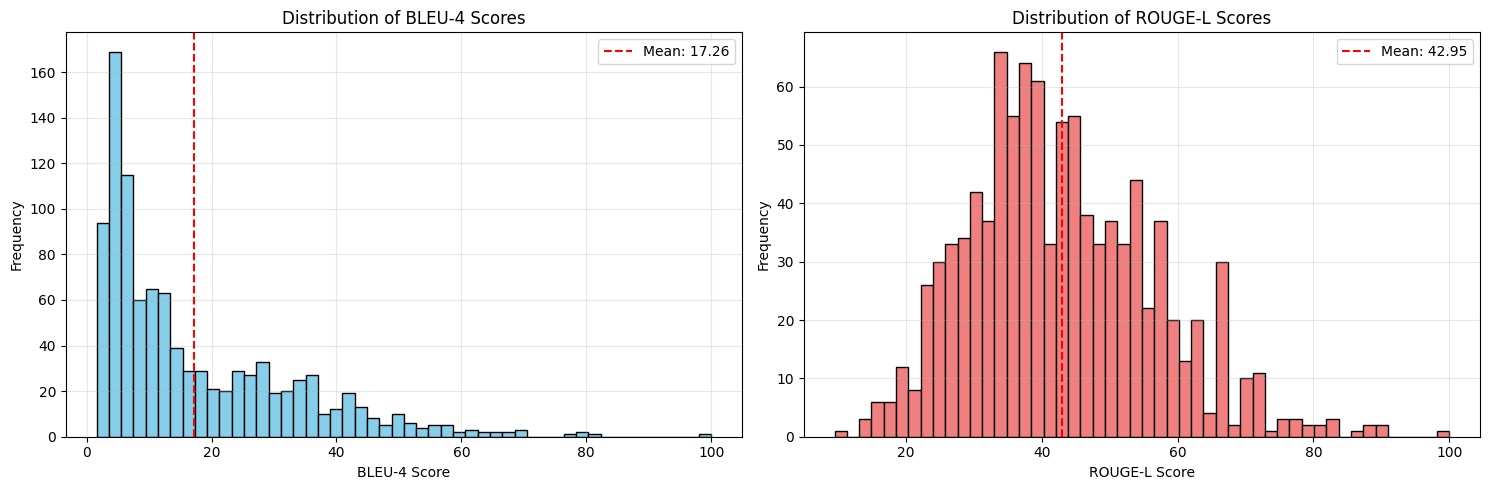

✓ Score distributions saved


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(individual_bleu4_scores, bins=50, color='skyblue', edgecolor='black')
axes[0].axvline(np.mean(individual_bleu4_scores), color='red', linestyle='--',
                label=f'Mean: {np.mean(individual_bleu4_scores):.2f}')
axes[0].set_xlabel('BLEU-4 Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of BLEU-4 Scores')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].hist(rouge_l_scores, bins=50, color='lightcoral', edgecolor='black')
axes[1].axvline(rouge_l_mean, color='red', linestyle='--',
                label=f'Mean: {rouge_l_mean:.2f}')
axes[1].set_xlabel('ROUGE-L Score')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of ROUGE-L Scores')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(config.results_dir, 'score_distributions.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Score distributions saved")

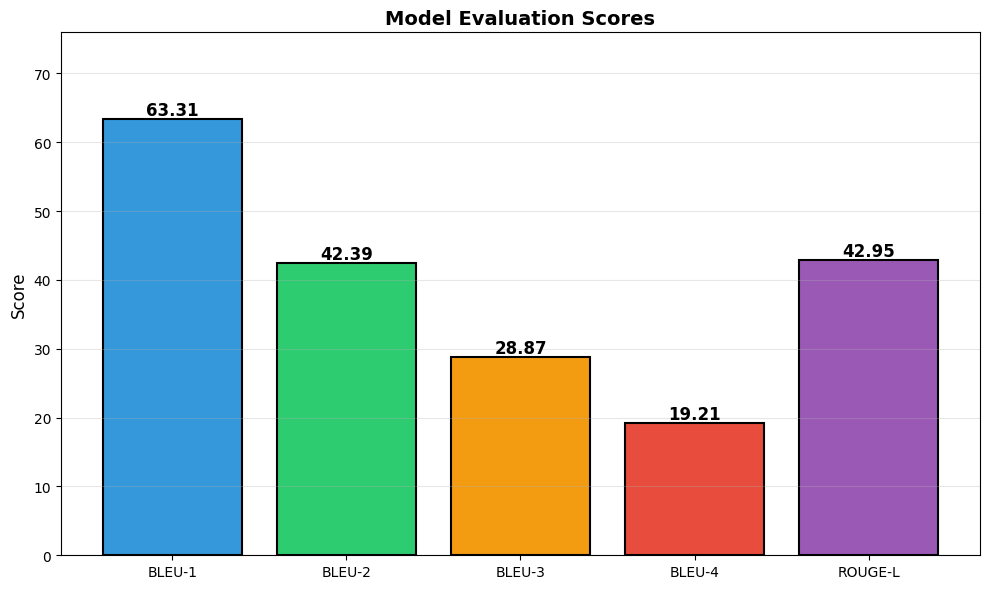

✓ Evaluation summary saved

📸 Creating sample predictions visualization...


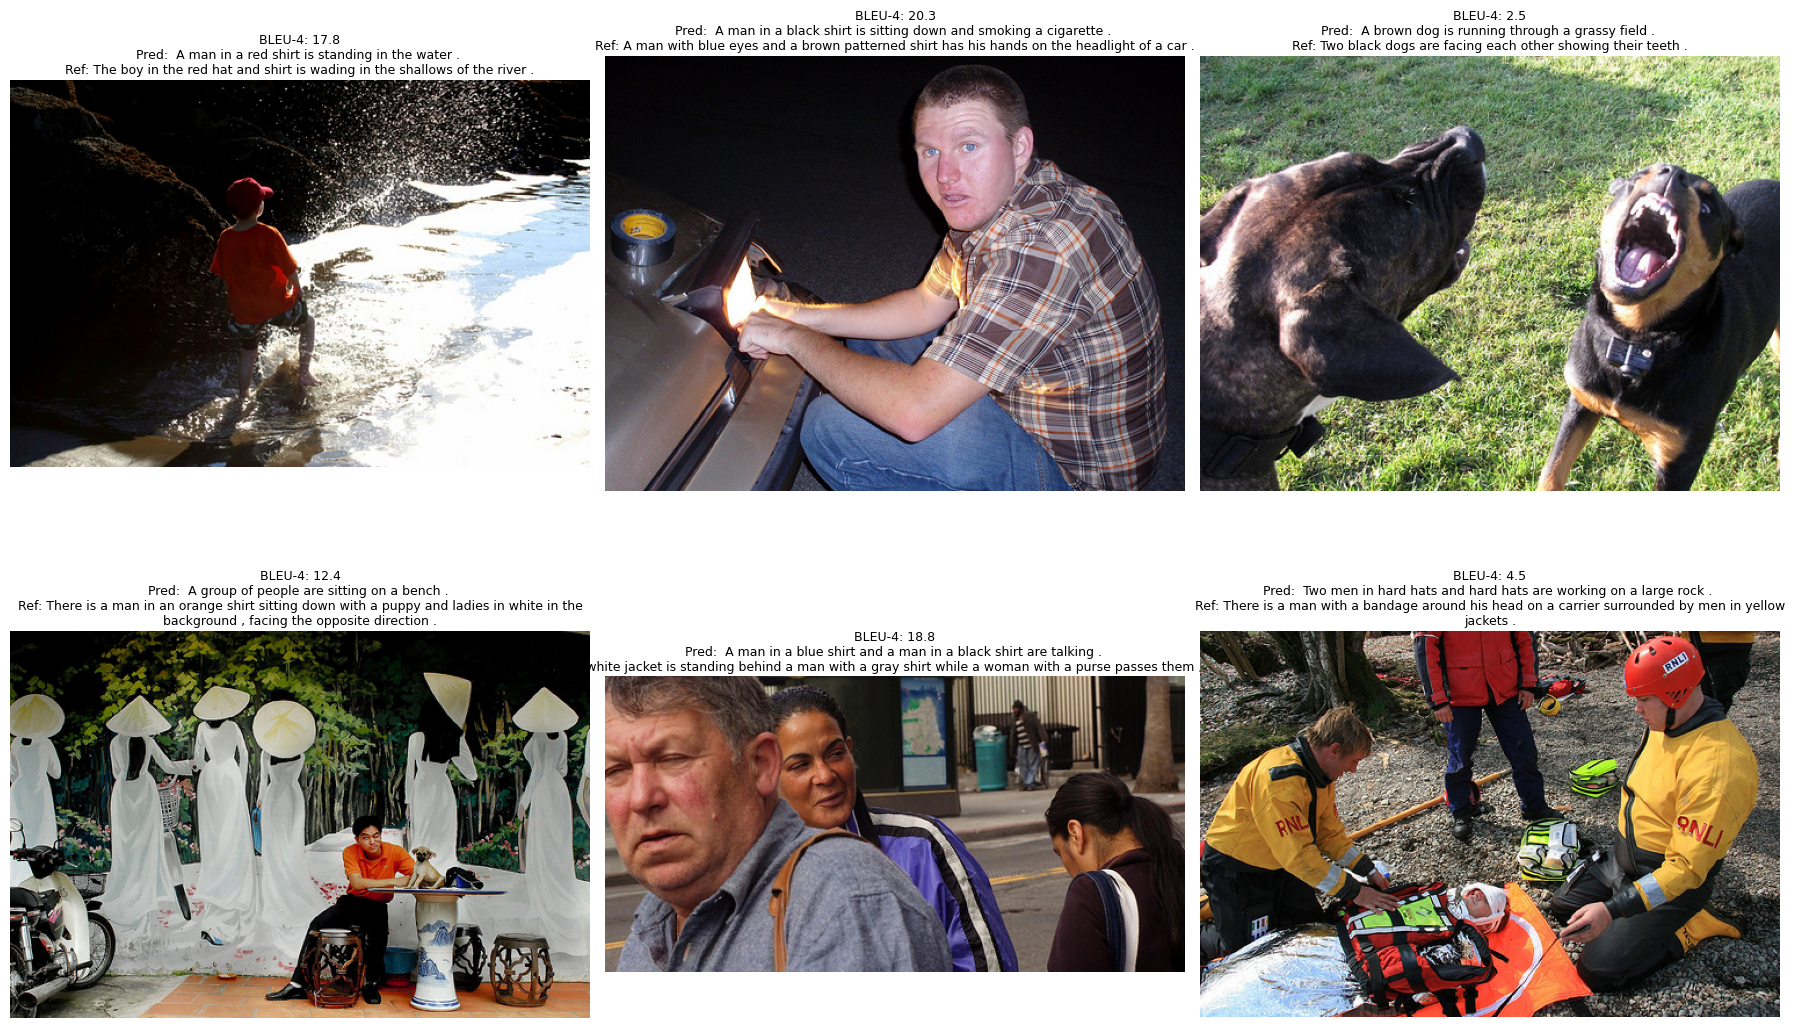

✓ Sample predictions saved


In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

scores = [bleu1, bleu2, bleu3, bleu4, rouge_l_mean]
labels = ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4', 'ROUGE-L']
colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c', '#9b59b6']

bars = ax.bar(labels, scores, color=colors, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Evaluation Scores', fontsize=14, fontweight='bold')
ax.set_ylim(0, max(scores) * 1.2)
ax.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(config.results_dir, 'evaluation_summary.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Evaluation summary saved")

# 3. Sample predictions with images
print("\n Creating sample predictions visualization...")

# Select 6 random samples
sample_indices = np.random.choice(len(all_predictions), min(6, len(all_predictions)), replace=False)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, sample_idx in enumerate(sample_indices):
    img_name = all_image_names[sample_idx]
    img_path = os.path.join(config.images_path, img_name)

    try:
        img = Image.open(img_path).convert('RGB')
        axes[idx].imshow(img)
    except:
        axes[idx].text(0.5, 0.5, 'Image not found', ha='center', va='center')

    axes[idx].axis('off')

    # Title with prediction and score
    title = f"BLEU-4: {individual_bleu4_scores[sample_idx]:.1f}\n"
    title += f"Pred: {all_predictions[sample_idx]}\n"
    title += f"Ref: {all_references[sample_idx][0]}"

    axes[idx].set_title(title, fontsize=9, wrap=True)

plt.tight_layout()
plt.savefig(os.path.join(config.results_dir, 'sample_predictions.png'), dpi=200, bbox_inches='tight')
plt.show()

print("Sample predictions saved")


In [ ]:
print(f"\nFINAL RESULTS:")
print(f"   BLEU-1: {bleu1:.2f}")
print(f"   BLEU-2: {bleu2:.2f}")
print(f"   BLEU-3: {bleu3:.2f}")
print(f"   BLEU-4: {bleu4:.2f}")
print(f"   ROUGE-L: {rouge_l_mean:.2f}")

print(f"\n Files saved to {config.results_dir}:")
print(f"   predictions.csv - All predictions")
print(f"   predictions_with_scores.csv - Predictions with BLEU/ROUGE scores")
print(f"   evaluation_scores.json - Summary scores")
print(f"   score_distributions.png - Score histograms")
print(f"   evaluation_summary.png - Bar chart of scores")
print(f"   sample_predictions.png - Sample images with captions")


📊 FINAL RESULTS:
   BLEU-1: 63.31
   BLEU-2: 42.39
   BLEU-3: 28.87
   BLEU-4: 19.21
   ROUGE-L: 42.95

📁 Files saved to /content/drive/MyDrive/flickr30k_images/processed/evaluation_results:
   • predictions.csv - All predictions
   • predictions_with_scores.csv - Predictions with BLEU/ROUGE scores
   • evaluation_scores.json - Summary scores
   • score_distributions.png - Score histograms
   • evaluation_summary.png - Bar chart of scores
   • sample_predictions.png - Sample images with captions


In [ ]:
COCO_BASE = '/content/drive/MyDrive/COCO2017'
COCO_IMAGES = os.path.join(COCO_BASE, 'val2017')
COCO_ANNOTATIONS = os.path.join(COCO_BASE, 'annotations')
COCO_CAPTION_FILE = os.path.join(COCO_ANNOTATIONS, 'captions_val2017.json')

print(f"\nCOCO Paths:")
print(f"   Images: {COCO_IMAGES}")
print(f"   Annotations: {COCO_ANNOTATIONS}")
print(f"   Caption file: {COCO_CAPTION_FILE}")

# Check if paths exist
if not os.path.exists(COCO_IMAGES):
    print(f"\n COCO images not found at {COCO_IMAGES}")
    print("   Please check the path!")
    COCO_AVAILABLE = False
else:
    print(f"  COCO images folder found")
    COCO_AVAILABLE = True

if not os.path.exists(COCO_CAPTION_FILE):
    print(f" COCO captions not found at {COCO_CAPTION_FILE}")
    print("   Please check the path!")
    COCO_AVAILABLE = False
else:
    print(f" COCO captions file found")



📁 COCO Paths:
   Images: /content/drive/MyDrive/COCO2017/val2017
   Annotations: /content/drive/MyDrive/COCO2017/annotations
   Caption file: /content/drive/MyDrive/COCO2017/annotations/captions_val2017.json
   ✓ COCO images folder found
   ✓ COCO captions file found


In [ ]:
if COCO_AVAILABLE:

    # Load COCO annotations
    print("\n Loading COCO captions JSON...")
    with open(COCO_CAPTION_FILE, 'r') as f:
        coco_data = json.load(f)

    print(f"Loaded COCO annotations")
    print(f"   Total images: {len(coco_data['images'])}")
    print(f"   Total annotations: {len(coco_data['annotations'])}")

    # Create image_id to filename mapping
    image_id_to_filename = {}
    for img in coco_data['images']:
        image_id_to_filename[img['id']] = img['file_name']

    # Group captions by image_id
    image_id_to_captions = defaultdict(list)
    for ann in coco_data['annotations']:
        image_id_to_captions[ann['image_id']].append(ann['caption'])

    print(f"Processed annotations")
    print(f"   Unique images with captions: {len(image_id_to_captions)}")

    # Sample 1000 random images
    NUM_COCO_SAMPLES = 1000
    all_image_ids = list(image_id_to_captions.keys())

    # Randomly sample
    np.random.seed(42)  # For reproducibility
    sampled_image_ids = np.random.choice(all_image_ids, NUM_COCO_SAMPLES, replace=False)

    print(f"\n  Randomly sampled {NUM_COCO_SAMPLES} images")

    # Create COCO dataset
    coco_samples = []
    for img_id in sampled_image_ids:
        filename = image_id_to_filename[img_id]
        captions = image_id_to_captions[img_id]
        coco_samples.append({
            'image_id': img_id,
            'filename': filename,
            'captions': captions
        })

    print(f" Created dataset with {len(coco_samples)} samples")


LOADING COCO ANNOTATIONS

📂 Loading COCO captions JSON...
   ✓ Loaded COCO annotations
   Total images: 5000
   Total annotations: 25014
   ✓ Processed annotations
   Unique images with captions: 5000

   ✓ Randomly sampled 1000 images
   ✓ Created dataset with 1000 samples


In [ ]:
if COCO_AVAILABLE:

    class COCOTestDataset(Dataset):
        def __init__(self, samples, images_dir, transform):
            self.samples = samples
            self.images_dir = images_dir
            self.transform = transform

            print(f"   Loaded {len(self.samples)} COCO samples")

        def __len__(self):
            return len(self.samples)

        def __getitem__(self, idx):
            sample = self.samples[idx]
            filename = sample['filename']
            captions = sample['captions']

            img_path = os.path.join(self.images_dir, filename)
            try:
                image = Image.open(img_path).convert('RGB')
                image = self.transform(image)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
                image = torch.zeros(3, 224, 224)

            return {
                'image': image,
                'image_name': filename,
                'captions': captions  # List of reference captions
            }

    # Custom collate function to handle varying caption counts
    def coco_collate_fn(batch):
        """
        Custom collate function for COCO dataset.
        Handles varying numbers of captions per image.
        """
        images = torch.stack([item['image'] for item in batch])
        image_names = [item['image_name'] for item in batch]
        captions = [item['captions'] for item in batch]  # List of lists, NOT stacked

        return {
            'image': images,
            'image_name': image_names,
            'captions': captions
        }

    # Create COCO dataset and dataloader
    coco_dataset = COCOTestDataset(coco_samples, COCO_IMAGES, test_transform)

    coco_loader = DataLoader(
        coco_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=config.num_workers,
        pin_memory=True,
        collate_fn=coco_collate_fn  # Use custom collate function
    )

    print(f"\n COCO DataLoader created with custom collate function")
    print(f"   Images: {len(coco_dataset)}")
    print(f"   Batches: {len(coco_loader)}")


CREATING COCO DATASET
   Loaded 1000 COCO samples

✓ COCO DataLoader created with custom collate function
   Images: 1000
   Batches: 16


In [ ]:
if COCO_AVAILABLE:

    coco_predictions = []
    coco_references = []
    coco_image_names = []

    print(f"\n Generating captions for {len(coco_dataset)} COCO images")

    for batch in tqdm(coco_loader, desc="Generating COCO captions"):
        images = batch['image']
        image_names = batch['image_name']
        reference_captions = batch['captions']  # This is now a list of lists

        batch_size = len(images)

        # Generate captions for each image in batch
        for i in range(batch_size):
            image = images[i]
            img_name = image_names[i]
            refs = reference_captions[i]  # Already a list of captions

            # Generate caption
            predicted_caption = model.generate_caption(image, max_length=30)

            # Store results
            coco_predictions.append(predicted_caption)
            coco_references.append(refs)
            coco_image_names.append(img_name)

    print(f"\n COCO caption generation complete!")
    print(f"   Total predictions: {len(coco_predictions)}")

    # Save COCO predictions
    coco_predictions_df = pd.DataFrame({
        'image': coco_image_names,
        'predicted_caption': coco_predictions,
        'reference_captions': ['; '.join(refs) for refs in coco_references]
    })
    coco_predictions_df.to_csv(os.path.join(config.results_dir, 'coco_predictions.csv'), index=False)
    print(f" COCO predictions saved to coco_predictions.csv")



GENERATING CAPTIONS FOR COCO SAMPLES

🤖 Generating captions for 1000 COCO images...


Generating COCO captions:   0%|          | 0/16 [00:00<?, ?it/s]


✓ COCO caption generation complete!
   Total predictions: 1000
   💾 COCO predictions saved to coco_predictions.csv


In [ ]:
if COCO_AVAILABLE:

    # Prepare references and hypotheses for BLEU calculation
    coco_references_tokenized = []
    coco_hypotheses_tokenized = []

    for refs, pred in zip(coco_references, coco_predictions):
        # Tokenize references
        refs_tokens = [ref.lower().split() for ref in refs]
        coco_references_tokenized.append(refs_tokens)

        # Tokenize prediction
        pred_tokens = pred.lower().split()
        coco_hypotheses_tokenized.append(pred_tokens)

    # Calculate corpus BLEU scores
    smoothing = SmoothingFunction()

    coco_bleu1 = corpus_bleu(coco_references_tokenized, coco_hypotheses_tokenized,
                        weights=(1.0, 0, 0, 0),
                        smoothing_function=smoothing.method1) * 100

    coco_bleu2 = corpus_bleu(coco_references_tokenized, coco_hypotheses_tokenized,
                        weights=(0.5, 0.5, 0, 0),
                        smoothing_function=smoothing.method1) * 100

    coco_bleu3 = corpus_bleu(coco_references_tokenized, coco_hypotheses_tokenized,
                        weights=(0.33, 0.33, 0.33, 0),
                        smoothing_function=smoothing.method1) * 100

    coco_bleu4 = corpus_bleu(coco_references_tokenized, coco_hypotheses_tokenized,
                        weights=(0.25, 0.25, 0.25, 0.25),
                        smoothing_function=smoothing.method1) * 100

    print(f"\n COCO BLEU Scores (Corpus):")
    print(f"   BLEU-1: {coco_bleu1:.2f}")
    print(f"   BLEU-2: {coco_bleu2:.2f}")
    print(f"   BLEU-3: {coco_bleu3:.2f}")
    print(f"   BLEU-4: {coco_bleu4:.2f}")

    # Calculate individual BLEU-4 scores
    coco_individual_bleu4 = []
    for refs_tokens, pred_tokens in zip(coco_references_tokenized, coco_hypotheses_tokenized):
        score = sentence_bleu(refs_tokens, pred_tokens,
                             weights=(0.25, 0.25, 0.25, 0.25),
                             smoothing_function=smoothing.method1) * 100
        coco_individual_bleu4.append(score)

    print(f"\n   Individual BLEU-4 statistics:")
    print(f"      Mean: {np.mean(coco_individual_bleu4):.2f}")
    print(f"      Median: {np.median(coco_individual_bleu4):.2f}")
    print(f"      Std: {np.std(coco_individual_bleu4):.2f}")
    print(f"      Min: {np.min(coco_individual_bleu4):.2f}")
    print(f"      Max: {np.max(coco_individual_bleu4):.2f}")


CALCULATING COCO BLEU SCORES

📊 COCO BLEU Scores (Corpus):
   BLEU-1: 44.21
   BLEU-2: 26.36
   BLEU-3: 15.48
   BLEU-4: 8.84

   Individual BLEU-4 statistics:
      Mean: 8.52
      Median: 4.91
      Std: 9.30
      Min: 1.23
      Max: 71.86


In [ ]:
if COCO_AVAILABLE:

    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

    coco_rouge_l_scores = []

    for refs, pred in zip(coco_references, coco_predictions):
        # Calculate ROUGE-L against all references and take the max
        scores = []
        for ref in refs:
            score = scorer.score(ref, pred)
            scores.append(score['rougeL'].fmeasure)

        # Take maximum score across all references
        max_score = max(scores)
        coco_rouge_l_scores.append(max_score * 100)

    coco_rouge_l_mean = np.mean(coco_rouge_l_scores)

    print(f"\nCOCO ROUGE Scores:")
    print(f"   ROUGE-L: {coco_rouge_l_mean:.2f}")
    print(f"      Mean: {coco_rouge_l_mean:.2f}")
    print(f"      Median: {np.median(coco_rouge_l_scores):.2f}")
    print(f"      Std: {np.std(coco_rouge_l_scores):.2f}")
    print(f"      Min: {np.min(coco_rouge_l_scores):.2f}")
    print(f"      Max: {np.max(coco_rouge_l_scores):.2f}")



CALCULATING COCO ROUGE SCORES

📊 COCO ROUGE Scores:
   ROUGE-L: 36.59
      Mean: 36.59
      Median: 34.78
      Std: 12.53
      Min: 8.70
      Max: 84.21


In [ ]:
if COCO_AVAILABLE:
    # Save COCO results
    coco_results = {
        'corpus_scores': {
            'BLEU-1': float(coco_bleu1),
            'BLEU-2': float(coco_bleu2),
            'BLEU-3': float(coco_bleu3),
            'BLEU-4': float(coco_bleu4),
            'ROUGE-L': float(coco_rouge_l_mean)
        },
        'individual_bleu4_stats': {
            'mean': float(np.mean(coco_individual_bleu4)),
            'median': float(np.median(coco_individual_bleu4)),
            'std': float(np.std(coco_individual_bleu4)),
            'min': float(np.min(coco_individual_bleu4)),
            'max': float(np.max(coco_individual_bleu4))
        },
        'rouge_l_stats': {
            'mean': float(coco_rouge_l_mean),
            'median': float(np.median(coco_rouge_l_scores)),
            'std': float(np.std(coco_rouge_l_scores)),
            'min': float(np.min(coco_rouge_l_scores)),
            'max': float(np.max(coco_rouge_l_scores))
        },
        'num_test_samples': len(coco_predictions),
        'dataset': 'COCO2017_val_subset',
        'model_checkpoint': best_checkpoint_path,
        'trained_epochs': checkpoint['epoch']
    }

    with open(os.path.join(config.results_dir, 'coco_evaluation_scores.json'), 'w') as f:
        json.dump(coco_results, f, indent=4)

    print(f"\nCOCO results saved to coco_evaluation_scores.json")

    # Add scores to predictions dataframe
    coco_predictions_df['bleu4_score'] = coco_individual_bleu4
    coco_predictions_df['rouge_l_score'] = coco_rouge_l_scores
    coco_predictions_df.to_csv(os.path.join(config.results_dir, 'coco_predictions_with_scores.csv'), index=False)

    print(f"COCO predictions with scores saved")


💾 COCO results saved to coco_evaluation_scores.json
💾 COCO predictions with scores saved


In [ ]:
if COCO_AVAILABLE:

    # Sort by BLEU-4 score
    coco_sorted_indices = np.argsort(coco_individual_bleu4)

    print("\n TOP 5 BEST COCO PREDICTIONS (Highest BLEU-4):")
    print("="*70)
    for i, idx in enumerate(coco_sorted_indices[-5:][::-1], 1):
        print(f"\n{i}. Image: {coco_image_names[idx]}")
        print(f"   BLEU-4: {coco_individual_bleu4[idx]:.2f}")
        print(f"   Predicted: {coco_predictions[idx]}")
        print(f"   References:")
        for j, ref in enumerate(coco_references[idx][:3], 1):  # Show first 3 refs
            print(f"      {j}. {ref}")

    print("TOP 5 WORST COCO PREDICTIONS (Lowest BLEU-4):")
    print("="*70)
    for i, idx in enumerate(coco_sorted_indices[:5], 1):
        print(f"\n{i}. Image: {coco_image_names[idx]}")
        print(f"   BLEU-4: {coco_individual_bleu4[idx]:.2f}")
        print(f"   Predicted: {coco_predictions[idx]}")
        print(f"   References:")
        for j, ref in enumerate(coco_references[idx][:3], 1):
            print(f"      {j}. {ref}")



COCO BEST AND WORST PREDICTIONS

🏆 TOP 5 BEST COCO PREDICTIONS (Highest BLEU-4):

1. Image: 000000346232.jpg
   BLEU-4: 71.86
   Predicted:  A group of people are walking in the rain . 
   References:
      1. these people are walking together down a road
      2. Three men who are walking in the sand.
      3. A group of people walking down a road.

2. Image: 000000038118.jpg
   BLEU-4: 63.12
   Predicted:  A skier is skiing down a snowy hill . 
   References:
      1. A man on his skis on a snowy slope. 
      2. I am unable to see the image above.
      3. The man is skiing down the snowy hill.

3. Image: 000000005529.jpg
   BLEU-4: 57.74
   Predicted:  A skier is skiing down a snowy hill . 
   References:
      1. A person on skis skiing down a mountain slope.
      2. A MAN IS SKIING ON THE SNOW SLOPES
      3. A skier is in the snow going downhill.

4. Image: 000000431848.jpg
   BLEU-4: 53.73
   Predicted:  A skateboarder is doing a trick on a ramp . 
   References:
      1. A m


COMPARISON: FLICKR30K vs COCO

📊 Score Comparison:

Metric          Flickr30k    COCO         Difference
-------------------------------------------------------
BLEU-1          63.31        44.21        -19.10
BLEU-2          42.39        26.36        -16.03
BLEU-3          28.87        15.48        -13.39
BLEU-4          19.21        8.84         -10.37
ROUGE-L         42.95        36.59        -6.36

💡 Analysis:
   • COCO scores are 10.37 points lower than Flickr30k (expected)
   • Model was trained on Flickr30k, so lower COCO scores show domain shift
   • COCO has more complex scenes with multiple objects


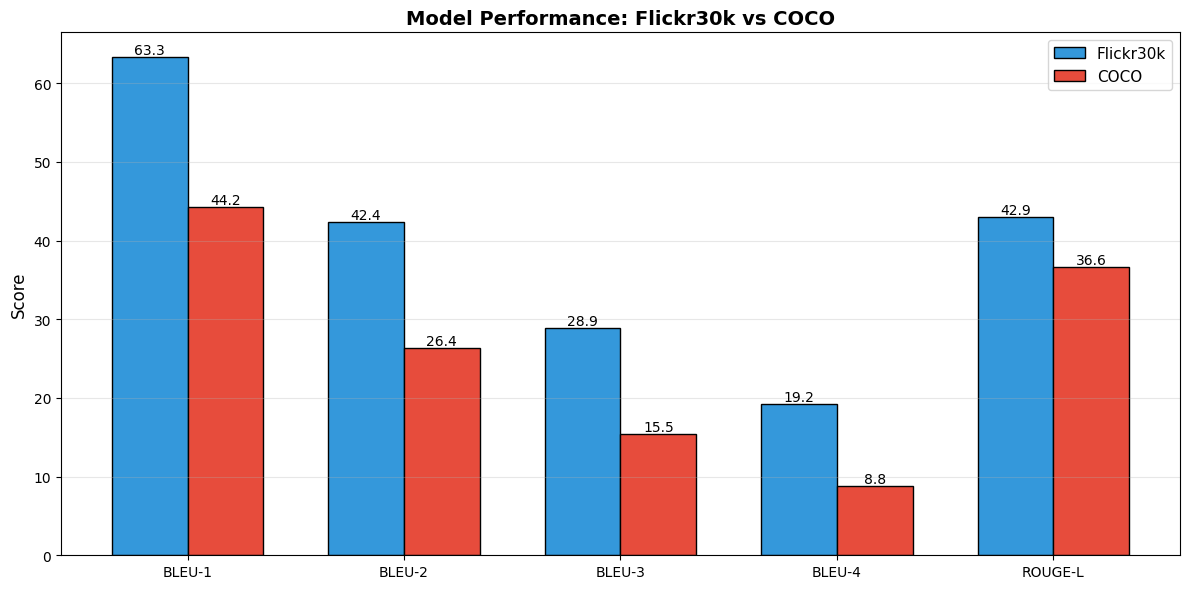


✓ Comparison chart saved


In [ ]:
if COCO_AVAILABLE:
    print("\n" + "="*70)
    print("COMPARISON: FLICKR30K vs COCO")
    print("="*70)

    print(f"\nScore Comparison:")
    print(f"\n{'Metric':<15} {'Flickr30k':<12} {'COCO':<12} {'Difference'}")
    print("-" * 55)
    print(f"{'BLEU-1':<15} {bleu1:<12.2f} {coco_bleu1:<12.2f} {coco_bleu1-bleu1:+.2f}")
    print(f"{'BLEU-2':<15} {bleu2:<12.2f} {coco_bleu2:<12.2f} {coco_bleu2-bleu2:+.2f}")
    print(f"{'BLEU-3':<15} {bleu3:<12.2f} {coco_bleu3:<12.2f} {coco_bleu3-bleu3:+.2f}")
    print(f"{'BLEU-4':<15} {bleu4:<12.2f} {coco_bleu4:<12.2f} {coco_bleu4-bleu4:+.2f}")
    print(f"{'ROUGE-L':<15} {rouge_l_mean:<12.2f} {coco_rouge_l_mean:<12.2f} {coco_rouge_l_mean-rouge_l_mean:+.2f}")

    print(f"\nAnalysis:")
    if coco_bleu4 < bleu4:
        diff = bleu4 - coco_bleu4
        print(f"    COCO scores are {diff:.2f} points lower than Flickr30k (expected)")
        print(f"    Model was trained on Flickr30k, so lower COCO scores show domain shift")
        print(f"    COCO has more complex scenes with multiple objects")
    else:
        print(f"    Surprisingly, COCO scores are similar or higher!")
        print(f"    Model generalizes well across datasets")

    # Create comparison visualization
    fig, ax = plt.subplots(figsize=(12, 6))

    x = np.arange(5)
    width = 0.35

    flickr_scores = [bleu1, bleu2, bleu3, bleu4, rouge_l_mean]
    coco_scores = [coco_bleu1, coco_bleu2, coco_bleu3, coco_bleu4, coco_rouge_l_mean]
    labels = ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4', 'ROUGE-L']

    bars1 = ax.bar(x - width/2, flickr_scores, width, label='Flickr30k', color='#3498db', edgecolor='black')
    bars2 = ax.bar(x + width/2, coco_scores, width, label='COCO', color='#e74c3c', edgecolor='black')

    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}',
                    ha='center', va='bottom', fontsize=10)

    ax.set_ylabel('Score', fontsize=12)
    ax.set_title('Model Performance: Flickr30k vs COCO', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(fontsize=11)
    ax.grid(True, axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(config.results_dir, 'flickr_vs_coco_comparison.png'), dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\nComparison chart saved")

In [ ]:
print(f"\n FLICKR30K RESULTS:")
print(f"   BLEU-1: {bleu1:.2f}")
print(f"   BLEU-2: {bleu2:.2f}")
print(f"   BLEU-3: {bleu3:.2f}")
print(f"   BLEU-4: {bleu4:.2f}")
print(f"   ROUGE-L: {rouge_l_mean:.2f}")

if COCO_AVAILABLE:
    print(f"\n COCO RESULTS:")
    print(f"   BLEU-1: {coco_bleu1:.2f}")
    print(f"   BLEU-2: {coco_bleu2:.2f}")
    print(f"   BLEU-3: {coco_bleu3:.2f}")
    print(f"   BLEU-4: {coco_bleu4:.2f}")
    print(f"   ROUGE-L: {coco_rouge_l_mean:.2f}")

print(f"\n All files saved to {config.results_dir}")

if COCO_AVAILABLE:
    print(f"\n   Flickr30k files:")
    print(f"   predictions.csv")
    print(f"   predictions_with_scores.csv")
    print(f"   evaluation_scores.json")
    print(f"   score_distributions.png")
    print(f"   evaluation_summary.png")
    print(f"   sample_predictions.png")
    print(f"\n   COCO files:")
    print(f"   coco_predictions.csv")
    print(f"   coco_predictions_with_scores.csv")
    print(f"   coco_evaluation_scores.json")
    print(f"   flickr_vs_coco_comparison.png")


📊 FLICKR30K RESULTS:
   BLEU-1: 63.31
   BLEU-2: 42.39
   BLEU-3: 28.87
   BLEU-4: 19.21
   ROUGE-L: 42.95

📊 COCO RESULTS:
   BLEU-1: 44.21
   BLEU-2: 26.36
   BLEU-3: 15.48
   BLEU-4: 8.84
   ROUGE-L: 36.59

📁 All files saved to /content/drive/MyDrive/flickr30k_images/processed/evaluation_results

   Flickr30k files:
   • predictions.csv
   • predictions_with_scores.csv
   • evaluation_scores.json
   • score_distributions.png
   • evaluation_summary.png
   • sample_predictions.png

   COCO files:
   • coco_predictions.csv
   • coco_predictions_with_scores.csv
   • coco_evaluation_scores.json
   • flickr_vs_coco_comparison.png
